<a href="https://colab.research.google.com/github/naokityokoyama/infnet/blob/main/Desafio_wide_pay_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string
import plotly.offline as py
import plotly.graph_objs as go
from fbprophet import Prophet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importando dados de 2017 a 2019 (pois devido a covid 19 e como os dados de 2020 não estão completos vamos descarta)

In [ ]:
dados = pd.read_csv('/content/drive/MyDrive/Data Science/cota-parlamentar.csv')

In [ ]:
dados = dados.dropna(subset=['datemissao'])

In [ ]:
dados = dados[(dados['datemissao'] >= '2017-01-01') & (dados['datemissao'] <= '2019-12-31')]

In [ ]:
dados = dados.sort_values(by='datemissao', ascending=False)

In [ ]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889367 entries, 2329193 to 2974784
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   codlegislatura             889367 non-null  int64  
 1   datemissao                 889367 non-null  object 
 2   idedocumento               889367 non-null  int64  
 3   idecadastro                886795 non-null  float64
 4   indtipodocumento           889367 non-null  int64  
 5   nucarteiraparlamentar      886795 non-null  float64
 6   nudeputadoid               889367 non-null  int64  
 7   nulegislatura              889367 non-null  int64  
 8   numano                     889367 non-null  int64  
 9   numespecificacaosubcota    889367 non-null  int64  
 10  numlote                    889367 non-null  int64  
 11  nummes                     889367 non-null  int64  
 12  numparcela                 889367 non-null  int64  
 13  numressarcimento      

In [ ]:
dados.isnull().sum()

codlegislatura                    0
datemissao                        0
idedocumento                      0
idecadastro                    2572
indtipodocumento                  0
nucarteiraparlamentar          2572
nudeputadoid                      0
nulegislatura                     0
numano                            0
numespecificacaosubcota           0
numlote                           0
nummes                            0
numparcela                        0
numressarcimento             539219
numsubcota                        0
sgpartido                         0
sguf                           2572
txnomeparlamentar                 0
txtcnpjcpf                        0
txtdescricao                      0
txtdescricaoespecificacao    692376
txtfornecedor                     8
txtnumero                         0
txtpassageiro                608830
txttrecho                    608142
vlrdocumento                      0
vlrglosa                          0
vlrliquido                  

Apos analisar as Features cheguei a conclusão que apenas as features importantes sao 
Nome do Deputado, data, descricao e valor 
os restos das colunas nao tem relevancia para nosso modelo


In [ ]:
dados = dados[['datemissao', 'txnomeparlamentar', 'txtdescricao', 'vlrdocumento']].dropna()
dados['datemissao'] = dados['datemissao'].apply(lambda x: x[0:10])

In [ ]:
dados.isnull().sum()

datemissao           0
txnomeparlamentar    0
txtdescricao         0
vlrdocumento         0
dtype: int64

In [ ]:
dados['datemissao'] = pd.to_datetime(dados['datemissao'], format='%Y/%m/%d')

In [ ]:
dados = dados.rename(columns={'datemissao': 'Data_Emissao', 'txnomeparlamentar': 'Nome','txtdescricao':'Despesa', 'vlrdocumento': 'Valor'})

In [ ]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889367 entries, 2329193 to 2974784
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Data_Emissao  889367 non-null  datetime64[ns]
 1   Nome          889367 non-null  object        
 2   Despesa       889367 non-null  object        
 3   Valor         889367 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 33.9+ MB


In [ ]:
#Upper()
nome = dados.Nome.str.upper()
dados.Nome = nome

Custo de cada deputado

In [ ]:
custo_deputado = dados.groupby('Nome')[['Valor']].sum().reset_index()
custo_deputado = custo_deputado.sort_values(by='Valor', ascending=False)
custo_deputado.head()

,Nome,Valor
455,JÉSSICA SALES,1623878.86
392,JHONATAN DE JESUS,1604115.16
291,FLAVIANO MELO,1591057.88
364,HIRAN GONÇALVES,1582710.85
52,ANDRÉ ABDON,1575126.76


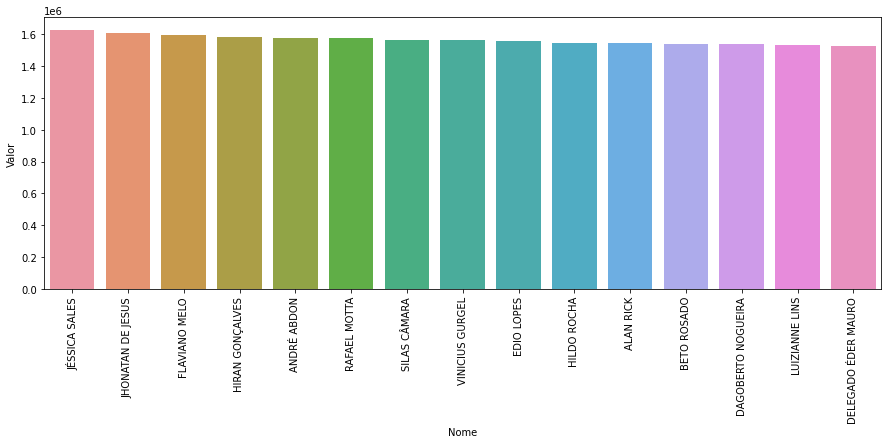

In [ ]:
#grafico com os 15 deputados com gastos 
plt.figure(figsize=(15,5))
g = sns.barplot(data=custo_deputado.head(15), x=custo_deputado.head(15)['Nome'], 
            y=custo_deputado.head(15)['Valor'])
g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [ ]:
dados_group = dados.groupby(['Despesa'])[['Valor']].sum()

In [ ]:
dados_group = dados_group.sort_values(by='Valor', ascending=False)
dados_group = dados_group.reset_index(drop=False)
#df_group.loc[22] = df_group.loc[21]
dados_group

,Despesa,Valor
0,Emissão Bilhete Aéreo,1.608588e+08
1,DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,1.595726e+08
2,LOCAÇÃO OU FRETAMENTO DE VEÍCULOS AUTOMOTORES,8.145122e+07
3,MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE ...,7.044234e+07
4,"CONSULTORIAS, PESQUISAS E TRABALHOS TÉCNICOS.",6.150988e+07
5,COMBUSTÍVEIS E LUBRIFICANTES.,5.359558e+07
6,TELEFONIA,2.018805e+07
7,PASSAGENS AÉREAS,8.453003e+06
8,SERVIÇOS POSTAIS,8.351200e+06
9,LOCAÇÃO OU FRETAMENTO DE AERONAVES,6.926327e+06


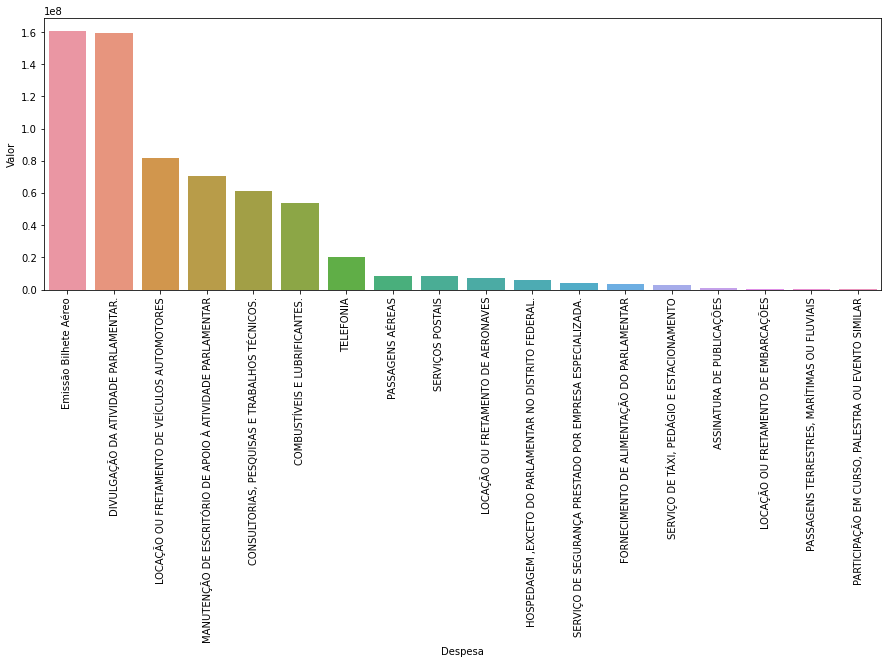

In [ ]:
#grafico com as maiores despesas
plt.figure(figsize=(15,5))
g = sns.barplot(data=dados_group, x=dados_group['Despesa'], 
            y=dados_group['Valor'])
g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [ ]:
#new_list = [ {'txtdescricao' :'BILHETE AEREO', 'vlrdocumento':passagem , 'numsubcota': 999.0}]
#add = pd.DataFrame(new_list)
#dados_group = dados_group.append(add,ignore_index=True)

In [ ]:
dados.groupby('Despesa').sum()

,Valor
Despesa,
ASSINATURA DE PUBLICAÇÕES,9.686748e+05
COMBUSTÍVEIS E LUBRIFICANTES.,5.359558e+07
"CONSULTORIAS, PESQUISAS E TRABALHOS TÉCNICOS.",6.150988e+07
DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.,1.595726e+08
Emissão Bilhete Aéreo,1.608588e+08
FORNECIMENTO DE ALIMENTAÇÃO DO PARLAMENTAR,3.574419e+06
"HOSPEDAGEM ,EXCETO DO PARLAMENTAR NO DISTRITO FEDERAL.",5.914565e+06
LOCAÇÃO OU FRETAMENTO DE AERONAVES,6.926327e+06
LOCAÇÃO OU FRETAMENTO DE EMBARCAÇÕES,4.012035e+05


Os maiores custos foram os seguintes:
- Divulgação de atividade parlamentar
- Emissao de passagem aerea
- Locação 
- Manutenção de escritorio
- Consultoria
- Combustivel 

In [ ]:
aereo = dados[dados['Despesa']=='Emissão Bilhete Aéreo']
divulgacao = dados[dados['Despesa']=='DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.']
locacao = dados[dados['Despesa']=='LOCAÇÃO OU FRETAMENTO DE VEÍCULOS AUTOMOTORES']
manutencao = dados[dados['Despesa']=='MANUTENÇÃO DE ESCRITÓRIO DE APOIO À ATIVIDADE PARLAMENTAR']
consultoria = dados[dados['Despesa']=='CONSULTORIAS, PESQUISAS E TRABALHOS TÉCNICOS.']

In [ ]:
def previsao(df):
  df = df[['Data_Emissao', 'Valor']].sort_values(by='Data_Emissao')
  df.columns = ['ds', 'y']
  df = df.groupby('ds', as_index=False).sum()
  m = Prophet()
  m.fit(df)
  future = m.make_future_dataframe(periods=365)
  forecast = m.predict(future)
  return forecast  

In [ ]:
class Resultado:
  def grafico (funcao_cast):
    fig1 = m.plot(funcao_cast)
    fig2 = m.plot_components(funcao_cast)
    
  def cast(funcao_cast):
    return funcao_cast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

  def print_retuldado(funcao_cast):
    return funcao_cast.yhat.sum()  


In [ ]:
loc = previsao(locacao)
aer = previsao(aereo)
divu = previsao(divulgacao)
manu = previsao(manutencao)
cons = previsao(consultoria)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
res_loc2018 = Resultado.cast(loc)[Resultado.cast(loc)['ds'].dt.year==2018]['yhat'].sum()
res_aer2018 = Resultado.cast(aer)[Resultado.cast(aer)['ds'].dt.year==2018]['yhat'].sum()
res_divu2018 = Resultado.cast(divu)[Resultado.cast(divu)['ds'].dt.year==2018]['yhat'].sum()
res_manu2018 = Resultado.cast(manu)[Resultado.cast(manu)['ds'].dt.year==2018]['yhat'].sum()
res_cons2018 = Resultado.cast(cons)[Resultado.cast(cons)['ds'].dt.year==2018]['yhat'].sum()

In [ ]:
res_loc2019 = Resultado.cast(loc)[Resultado.cast(loc)['ds'].dt.year==2019]['yhat'].sum()
res_aer2019 = Resultado.cast(aer)[Resultado.cast(aer)['ds'].dt.year==2019]['yhat'].sum()
res_divu2019 = Resultado.cast(divu)[Resultado.cast(divu)['ds'].dt.year==2019]['yhat'].sum()
res_manu2019 = Resultado.cast(manu)[Resultado.cast(manu)['ds'].dt.year==2019]['yhat'].sum()
res_cons2019 = Resultado.cast(cons)[Resultado.cast(cons)['ds'].dt.year==2019]['yhat'].sum()

In [ ]:
res_loc = Resultado.print_retuldado(loc)
res_aer = Resultado.print_retuldado(aer)
res_divu = Resultado.print_retuldado(divu)
res_manu = Resultado.print_retuldado(manu)
res_cons = Resultado.print_retuldado(cons)

In [ ]:
#grafico Orçamento 2019 e 2020
trace1 = go.Bar(x = ['Locação', 'Aereo', 'Divulgação', 'Manuntenção', 'Consultoria'],
                y = [res_loc, res_aer, res_divu, res_manu, res_cons],
                name = '2020')


trace2 = go.Bar(x = ['Locação', 'Aereo', 'Divulgação', 'Manuntenção', 'Consultoria'],
                y = [res_loc2019, res_aer2019, res_divu2019, res_manu2019, res_cons2019],
                name='2019')
data = [trace1, trace2]
py.iplot(data)

In [ ]:
despesa_1 = dados[(dados['Despesa'] =='Emissão Bilhete Aéreo')]['Valor'].sum()
despesa_2 = dados[(dados['Despesa'] =='DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.')]['Valor'].sum()
outras_despesas = dados[(dados['Despesa'] !='Emissão Bilhete Aéreo') & (dados['Despesa'] !='DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR.')]['Valor'].sum()

In [ ]:
total1_2 = despesa_1 + despesa_2

In [ ]:
#grafico Despesa 1, 2 vx outras
trace1 = go.Bar(x = ['Aereo+Divulgacao', 'Aereo', 'Divulgacao', 'Demais'],
                y = [total1_2, despesa_1, despesa_2, outras_despesas],
                name = 'Despesas')

data = [trace1]
py.iplot(data)

In [ ]:
# Gráfico usando apenas marcadores
trace1 = go.Scatter(x = ['2018', '2019', '2020'],
                 y = [res_loc2018, res_loc2019, res_loc],
                    mode = 'lines',
                    name = 'Locação')

trace2 = go.Scatter(x = ['2018', '2019', '2020'],
                 y = [res_aer2018, res_aer2019, res_aer],
                    mode = 'lines',
                    name = 'Aereo')

trace3= go.Scatter(x = ['2018', '2019', '2020'],
                 y = [res_divu2018, res_divu2019, res_divu],
                    mode = 'lines',
                    name = 'Divulgação')

trace4 = go.Scatter(x = ['2018', '2019', '2020'],
                 y = [res_manu2018, res_manu2019, res_manu],
                    mode = 'lines',
                    name = 'Manutenção')

trace5 = go.Scatter(x = ['2018', '2019', '2020'],
                 y = [res_cons2018, res_cons2019, res_cons],
                    mode = 'lines',
                    name = 'Consultoria')
data = [trace1, trace2, trace3, trace4, trace5]
py.iplot(data)

## Conclusão

Nesse breve estudo de caso podemos ver os gastos dos Deputados 
Os 15 que mais gastaram 
As maiores despesas 
E a previsão que deveria ser para 2020

Podemos tambem observa que os maiores custos foram das Passagens Aereas e Divulgação 

Temos que tendender melhor o porque esse custo representa uma grande diferença com relação aos demais

Podemos ver em uns dos graficos acima que essas 2 despesas (divulgacao e Aereo ) somadas representam 50% das despesas totais ou seja de 22 despesas listadas neste estudo de caso 2 representa 50% 

Então uma acao imediata seria reduzir essa despesa


In [ ]:
dados.to_csv('dados.csv', index=False)